## Setup

In [1]:
import os
from dotenv import load_dotenv
from src import util

import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_recall_curve
import optuna
import joblib

C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

slided_df_path = os.path.join(os.getenv("SLIDED_DFS_CSV_PATH"), "data_slided_V3.parquet")
target_class = 'target_class_in_24h'
target_flux = 'target_flux_in_24h'
target_columns = [target_class, target_flux]

df_model_input = util.create_df_model_input_opt(slided_df_path, target_columns, "xl_")

Erro ao ler o esquema do Parquet: [WinError 3] Failed to open local file 'G:/My Drive/Solar_Flares/Data/slided_dfs/data_slided_V3.parquet'. Detail: [Windows error 3] The system cannot find the path specified.



FileNotFoundError: [Errno 2] No such file or directory: 'G:\\My Drive\\Solar_Flares\\Data\\slided_dfs\\data_slided_V3.parquet'

## Model 3 - 'Specialist 910'

### Preparing Data

In [3]:
specialist_910_pool = df_model_input[df_model_input[target_class] > 2].copy()

In [4]:
train_pct = 0.7
val_pct = (1-train_pct)/2
test_pct = (1-train_pct)/2

specialist_910_data = util.prepare_data(df_model_input = specialist_910_pool,
                                        target_class_col = target_class,
                                        lambda_function = lambda lb: 1 if lb >= 4 else 0,
                                        train_pct = train_pct,
                                        val_pct = val_pct,
                                        target_flux_col = target_flux)

### Buffer Zone

In [9]:
buffer_inf_limit = 8.0e-6
buffer_sup_limit = 2.0e-5
buffer_mask = ((specialist_910_data['flux']['train'] > buffer_inf_limit) &
               (specialist_910_data['flux']['train'] < buffer_sup_limit))

flux_original = specialist_910_data['flux']['train'].copy()
flux_filtered = flux_original[~buffer_mask]

In [10]:
# HARD BUFFER
# # specialist_910_data['x']['train'] = specialist_910_data['x']['train'][~buffer_mask]
# # specialist_910_data['y']['train'] = specialist_910_data['y']['train'][~buffer_mask]
# # specialist_910_data['flux']['train'] = specialist_910_data['flux']['train'][~buffer_mask]

In [11]:
# SOFT BUFFER
weights_train = np.ones(specialist_910_data['y']['train'].shape[0])
weights_train[buffer_mask] = 0.2

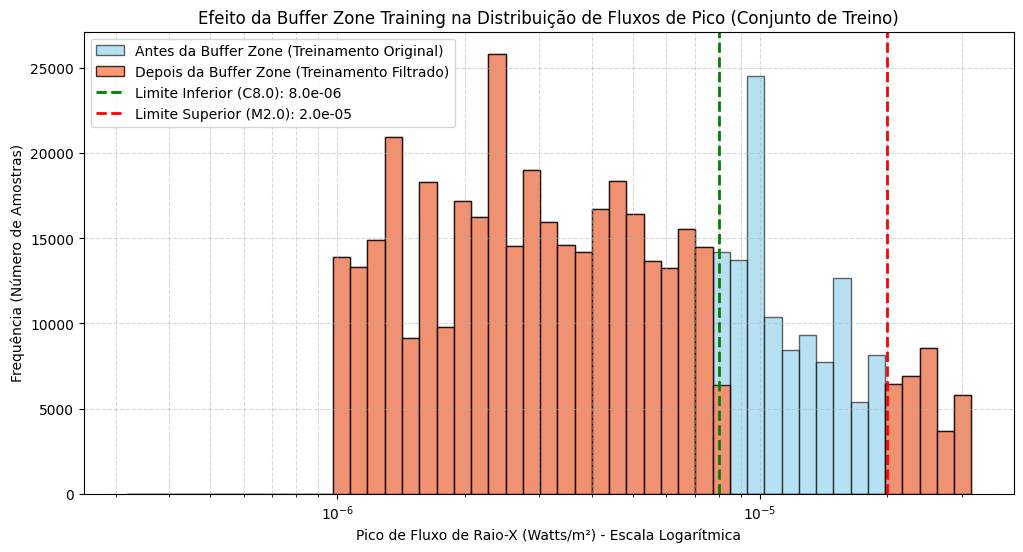

In [12]:
plt.figure(figsize=(12, 6))

plt.hist(flux_original, bins=np.logspace(-6.5, -4.5, 50),
         alpha=0.6, label='Inside Buffer Zone (Original)', color='skyblue', edgecolor='black')

plt.hist(flux_filtered, bins=np.logspace(-6.5, -4.5, 50),
         alpha=0.8, label='Outside Buffer Zone (Filtered)', color='coral', edgecolor='black')

plt.axvline(buffer_inf_limit, color='green', linestyle='--', linewidth=2, label=f' Limite Inferior (C8.0): {buffer_inf_limit:.1e}')
plt.axvline(buffer_sup_limit, color='red', linestyle='--', linewidth=2, label=f'Limite Superior (M2.0): {buffer_sup_limit:.1e}')

plt.xscale('log')
plt.xlabel('X-Ray Flux (Watts/m²) - Logarithmic Scale')
plt.ylabel('Frequência (Número de Amostras)')
plt.title('Efeito da Buffer Zone Training na Distribuição de Fluxos de Pico (Conjunto de Treino)')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

### Training and Parameter Tuning

In [7]:
counts = specialist_910_data['y']['train'].value_counts()
scale_pos_weight = counts[0] / counts[1]

print("\nDistribuição do Alvo(no treino):")
print(f"Classe 0 (C): {counts[0]} amostras")
print(f"Classe 1 (MX):  {counts[1]} amostras")
print(f"Scale_pos_weight para M2: {scale_pos_weight:.2f}")


Distribuição do Alvo(no treino):
Classe 0 (C): 384290 amostras
Classe 1 (MX):  173933 amostras
Scale_pos_weight para M2: 2.21


In [8]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': 1000,
        'random_state': 1502,
        'n_jobs': -1,
        'early_stopping_rounds': 50,

        'device': 'cuda',

        'scale_pos_weight': trial.suggest_float("scale_pos_weight", 1.5, 7.5, log=True),

        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model_ = xgb.XGBClassifier(**params)

    model_.fit(
        specialist_910_data['x']['train'],
        specialist_910_data['y']['train'],
        eval_set=[(specialist_910_data['x']['val'], specialist_910_data['y']['val'])],
        sample_weight=weights_train,
        verbose=False
    )

    y_pred_val = model_.predict(specialist_910_data['x']['val'])


    # score = f1_score(specialist_910_data['y']['val'], y_pred_val, average='macro')


    recall_c = recall_score(specialist_910_data['y']['val'], y_pred_val, pos_label=0)
    recall_mx = recall_score(specialist_910_data['y']['val'], y_pred_val, pos_label=1)
    w_c = 2.0
    w_mx = 1.0
    score = (w_c * recall_c) + (w_mx * recall_mx)

    return score

In [9]:
study = optuna.create_study(direction='maximize')
print("\nIniciando o tuning...")
study.optimize(objective, n_trials=100)

print("\nBusca concluída!")
print(f"Melhor valor: {study.best_value:.4f}")
print("Melhores parâmetros encontrados:")
print(study.best_params)

[I 2025-11-19 17:16:20,460] A new study created in memory with name: no-name-82b9846f-92cd-45b3-9e82-cfeacfd41b41



Iniciando o tuning...


C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [17:16:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-11-19 17:16:27,410] Trial 0 finished with value: 2.148313570609482 and parameters: {'scale_pos_weight': 3.006045267357743, 'max_depth': 4, 'learning_rate': 0.01290579369835382, 'subsample': 0.9967530313792133, 'colsample_bytree': 0.7773673379426896, 'gamma': 3.967880869083378, 'min_child_weight': 3}. Best is trial 0 with value: 2.148313570609482.
[I 2025-11-19 17:16:36,358] Trial 1 finished wit


Busca concluída!
Melhor valor: 2.2467
Melhores parâmetros encontrados:
{'scale_pos_weight': 1.540355894297004, 'max_depth': 3, 'learning_rate': 0.2952913952536346, 'subsample': 0.7541827463324607, 'colsample_bytree': 0.6212869673254151, 'gamma': 1.966966375332974, 'min_child_weight': 1}


In [10]:
great_filter_params = study.best_params

great_filter_params.update({
    'n_estimators': 1000,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 1502,
    'n_jobs': -1,
    'early_stopping_rounds': 50
})

In [11]:
specialist_910_model = xgb.XGBClassifier(**great_filter_params)

print("\nIniciando o treinamento...")
specialist_910_model.fit(
    specialist_910_data['x']['train'],
    specialist_910_data['y']['train'],
    eval_set=[(specialist_910_data['x']['val'], specialist_910_data['y']['val'])],
    verbose=100
)
print("Treinamento concluído.")


Iniciando o treinamento...
[0]	validation_0-logloss:0.55000
[61]	validation_0-logloss:0.48139
Treinamento concluído.


### Threshold Tuning

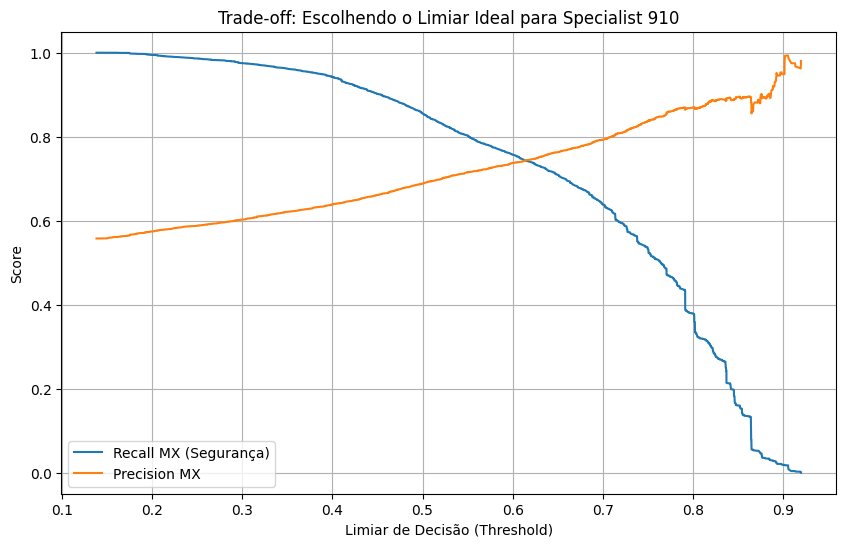

--- Ponto de Operação Sugerido ---
      Threshold  Precision (MX)  Recall (MX)
3294   0.453865        0.663325      0.89997

--- Relatório com Limiar Ajustado ---
              precision    recall  f1-score   support

       C (0)       0.77      0.42      0.55     52860
      MX (1)       0.66      0.90      0.76     66760

    accuracy                           0.69    119620
   macro avg       0.72      0.66      0.65    119620
weighted avg       0.71      0.69      0.67    119620



In [12]:
y_proba = specialist_910_model.predict_proba(specialist_910_data['x']['test'])[:, 1]
y_true = specialist_910_data['y']['test']

precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)

df_thresholds = pd.DataFrame({
    'Threshold': thresholds,
    'Precision (MX)': precisions[:-1],
    'Recall (MX)': recalls[:-1]
})

plt.figure(figsize=(10, 6))
plt.plot(df_thresholds['Threshold'], df_thresholds['Recall (MX)'], label='Recall MX (Segurança)')
plt.plot(df_thresholds['Threshold'], df_thresholds['Precision (MX)'], label='Precision MX')
plt.xlabel('Limiar de Decisão (Threshold)')
plt.ylabel('Score')
plt.title('Trade-off: Escolhendo o Limiar Ideal para Specialist 910')
plt.legend()
plt.grid(True)
plt.show()

target_recall = 0.90
optimal_row = df_thresholds.iloc[(df_thresholds['Recall (MX)'] - target_recall).abs().argsort()[:1]]
print("--- Ponto de Operação Sugerido ---")
print(optimal_row)

optimal_thresh = optimal_row['Threshold'].values[0]

y_pred_new_threshold = (y_proba >= optimal_thresh).astype(int)

print("\n--- Relatório com Limiar Ajustado ---")
print(classification_report(y_true, y_pred_new_threshold, target_names=['C (0)', 'MX (1)']))

### Results

--- Relatório de Classificação (Conjunto de Teste) ---

              precision    recall  f1-score   support

       C (0)       0.74      0.51      0.60     52860
      MX (1)       0.69      0.86      0.76     66760

    accuracy                           0.70    119620
   macro avg       0.71      0.68      0.68    119620
weighted avg       0.71      0.70      0.69    119620


--- Matriz de Confusão ---


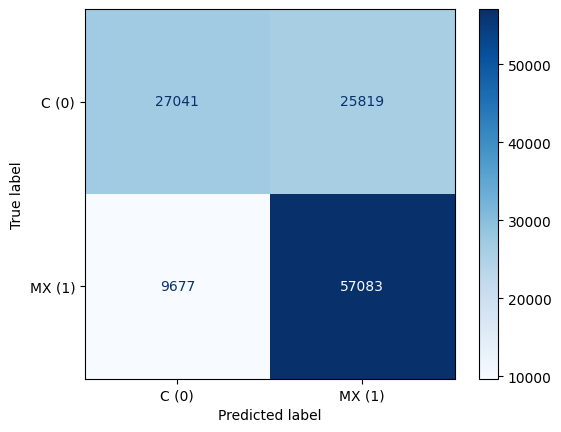

In [13]:
specialist_910_y_pred = specialist_910_model.predict(specialist_910_data['x']['test'])

print("--- Relatório de Classificação (Conjunto de Teste) ---\n")
print(classification_report(specialist_910_data['y']['test'], specialist_910_y_pred, target_names=['C (0)', 'MX (1)']))

print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(specialist_910_data['y']['test'], specialist_910_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['C (0)', 'MX (1)'])
disp.plot(cmap='Blues')
plt.show()

### Evaluating Tradeoff Cost

In [15]:
specialist_910_y_multiclass = df_model_input[target_class]

val_end = int(len(specialist_910_data['x']['all']) * (val_pct + train_pct))
specialist_910_y_multi_truth = specialist_910_y_multiclass.iloc[val_end:]

In [16]:
df_analysis = pd.DataFrame(index=specialist_910_data['y']['test'].index)
df_analysis['binary_truth'] = specialist_910_data['y']['test']
df_analysis['binary_pred'] = specialist_910_y_pred
df_analysis['multiclass_truth'] = specialist_910_y_multi_truth

is_false_negative = (df_analysis['binary_truth'] == 1) & (df_analysis['binary_pred'] == 0)
df_false_negatives = df_analysis[is_false_negative]
print(f"Número total de Falsos Negativos encontrados: {len(df_false_negatives)}")

Número total de Falsos Negativos encontrados: 9677


In [17]:
df_false_negatives

,binary_truth,binary_pred,multiclass_truth
ds,,,
2022-09-11 23:30:00,1,0,4.0
2022-09-11 23:40:00,1,0,4.0
2022-09-11 23:50:00,1,0,4.0
2022-09-12 00:00:00,1,0,4.0
2022-09-12 00:10:00,1,0,4.0
...,...,...,...
2024-12-04 02:30:00,1,0,4.0
2024-12-04 02:40:00,1,0,4.0
2024-12-04 08:00:00,1,0,4.0


### Exporting Model

In [ ]:
# model_save_path = r'../../models/specialist_910/specialist_910_model_v1.joblib'
# joblib.dump(specialist_910_model, model_save_path)
# print(f"Modelo salvo em {model_save_path}")